In [6]:
import numpy as np
import cv2  # OpenCVライブラリ

import matplotlib.pyplot as plt 
%matplotlib inline

import torch

# infer

In [8]:
!ls -lh weights

total 5.6G
-rw-rw-r-- 1 ubuntu ubuntu 101M Sep 11 02:42 ssd300_100.pth
-rw-rw-r-- 1 ubuntu ubuntu 101M Sep 11 00:59 ssd300_10.pth
-rw-rw-r-- 1 ubuntu ubuntu 101M Sep 11 02:53 ssd300_110.pth
-rw-rw-r-- 1 ubuntu ubuntu 101M Sep 11 03:05 ssd300_120.pth
-rw-rw-r-- 1 ubuntu ubuntu 101M Sep 11 03:16 ssd300_130.pth
-rw-rw-r-- 1 ubuntu ubuntu 101M Sep 11 03:28 ssd300_140.pth
-rw-rw-r-- 1 ubuntu ubuntu 101M Sep 11 03:39 ssd300_150.pth
-rw-rw-r-- 1 ubuntu ubuntu 101M Sep 11 03:51 ssd300_160.pth
-rw-rw-r-- 1 ubuntu ubuntu 101M Sep 11 04:02 ssd300_170.pth
-rw-rw-r-- 1 ubuntu ubuntu 101M Sep 11 04:14 ssd300_180.pth
-rw-rw-r-- 1 ubuntu ubuntu 101M Sep 11 04:25 ssd300_190.pth
-rw-rw-r-- 1 ubuntu ubuntu 101M Sep 11 04:36 ssd300_200.pth
-rw-rw-r-- 1 ubuntu ubuntu 101M Sep 11 01:10 ssd300_20.pth
-rw-rw-r-- 1 ubuntu ubuntu 101M Sep 11 01:22 ssd300_30.pth
-rw-rw-r-- 1 ubuntu ubuntu 101M Sep 11 01:33 ssd300_40.pth
-rw-rw-r-- 1 ubuntu ubuntu 101M Sep 11 01:44 ssd300_50.pth
-rw-rw-r-- 1 ubuntu ubuntu 101M Se

In [9]:
from utils.feature_piramid_network import FPNSSD as SSD

voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']

# SSD300の設定
ssd_cfg = {
    'num_classes': 21,  # 背景クラスを含めた合計クラス数
    'input_size': 300,  # 画像の入力サイズ
    'bbox_aspect_num': [4, 6, 6, 6, 4, 4],  # 出力するDBoxのアスペクト比の種類
    'feature_maps': [38, 19, 10, 5, 3, 1],  # 各sourceの画像サイズ
    'steps': [8, 16, 32, 64, 100, 300],  # DBOXの大きさを決める
    'min_sizes': [30, 60, 111, 162, 213, 264],  # DBOXの大きさを決める
    'max_sizes': [60, 111, 162, 213, 264, 315],  # DBOXの大きさを決める
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
}

# SSDネットワークモデル
net = SSD(phase="inference", cfg=ssd_cfg)

# SSDの学習済みの重みを設定
net_weights = torch.load('./weights/ssd_fpn_300_160.pth',
                         map_location={'cuda:0': 'cpu'})

net.load_state_dict(net_weights)

print('loaded the trained weights')


loaded the trained weights


In [10]:
import cv2
image_file_path = "./horse/sample_horse.jpg"
img = cv2.imread(image_file_path)  # [高さ][幅][色BGR]
img.shape

(866, 1300, 3)

cuda:0
./horse/uma-san2.jpg


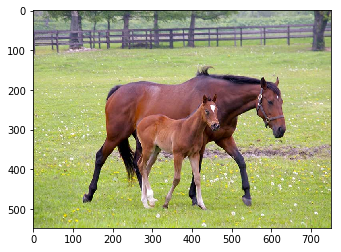

torch.Size([1, 21, 200, 5])
./horse/sample_horse.jpg


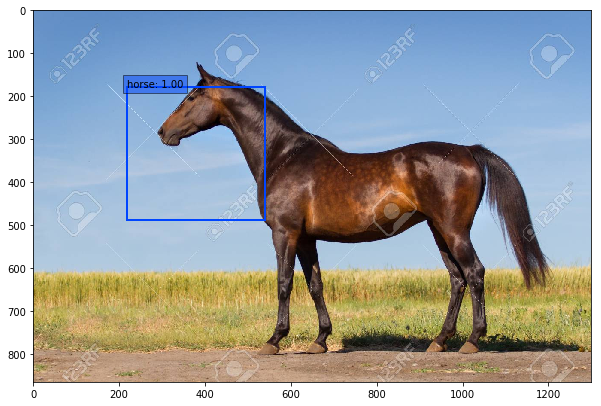

torch.Size([1, 21, 200, 5])
./horse/20101210_an01_012.jpg


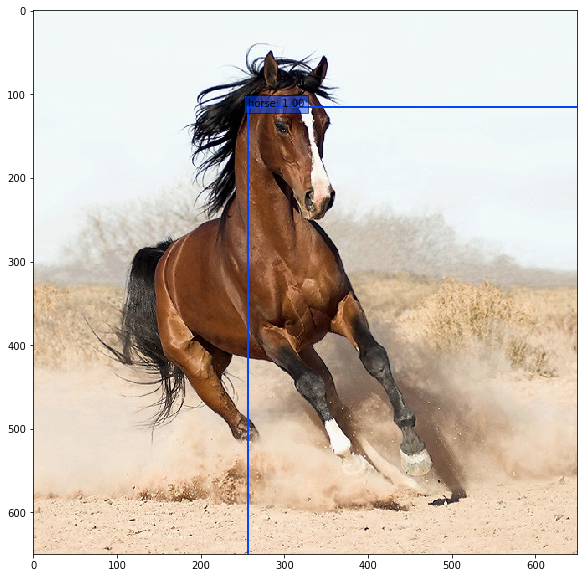

torch.Size([1, 21, 200, 5])
./horse/pic_1.jpg


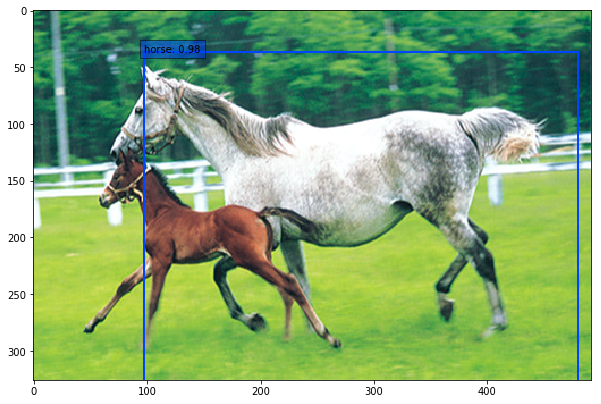

torch.Size([1, 21, 200, 5])
./horse/horses-14148.jpg


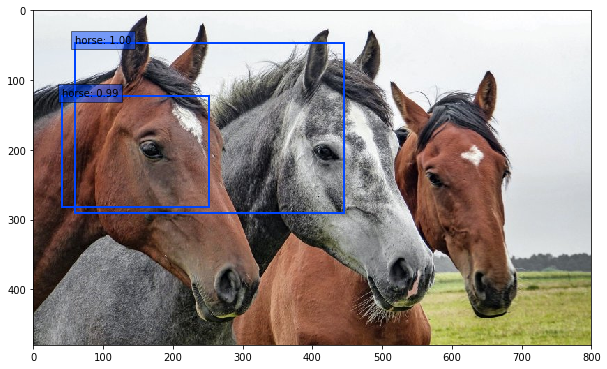

torch.Size([1, 21, 200, 5])
./horse/heritage_046_main1.jpg


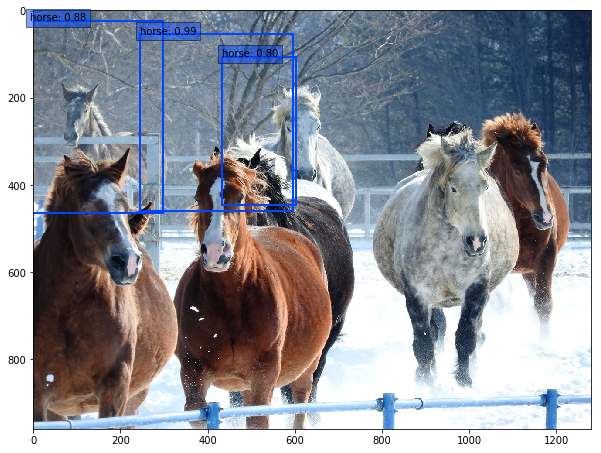

torch.Size([1, 21, 200, 5])
./horse/images.jpg


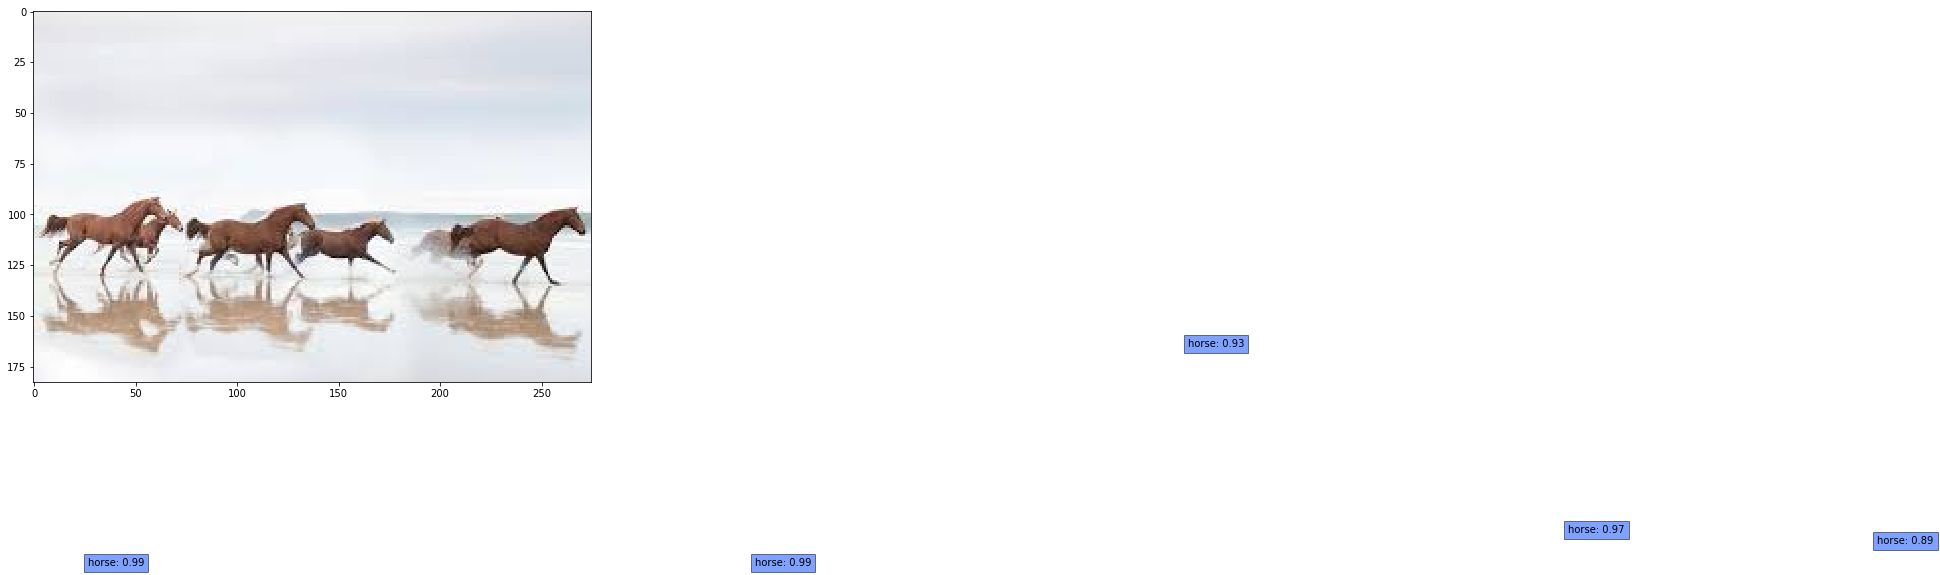

torch.Size([1, 21, 200, 5])
./horse/sample.JPG


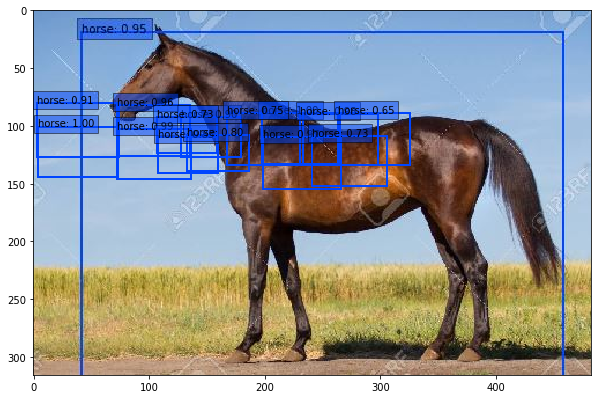

torch.Size([1, 21, 200, 5])


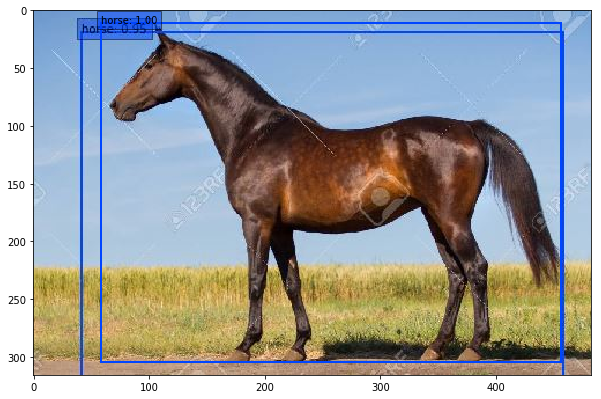

In [11]:
from utils.ssd_model import DataTransform
import glob
# 画像に対する予測
from utils.ssd_predict_show import SSDPredictShow
# 1. 画像読み込み
#image_file_path = "../../VOCdevkit/VOC2007/JPEGImages/009961.jpg"
image_file_path = "./horse/*"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
ssd = SSDPredictShow(eval_categories=voc_classes, net=net, device=device)

for imp in glob.glob(image_file_path):
    print(imp)
    img = cv2.imread(imp)  # [高さ][幅][色BGR]
    height, width, channels = img.shape  # 画像のサイズを取得

    # 2. 元画像の表示
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

    # 3. 前処理クラスの作成
    color_mean = (104, 117, 123)  # (BGR)の色の平均値
    input_size = 300  # 画像のinputサイズを300×300にする
    transform = DataTransform(input_size, color_mean)

    # 4. 前処理
    phase = "val"
    img_transformed, boxes, labels = transform(
        img, phase, "", "")  # アノテーションはないので、""にする
    img = torch.from_numpy(img_transformed[:, :, (2, 1, 0)]).permute(2, 0, 1)

    # 5. SSDで予測
    net.eval()  # ネットワークを推論モードへ
    x = img.unsqueeze(0)  # ミニバッチ化：torch.Size([1, 3, 300, 300])
    detections = net(x.to(device))

    print(detections.shape)
    #print(detections)

    # output : torch.Size([batch_num, 21, 200, 5])
    #  =（batch_num、クラス、confのtop200、規格化されたBBoxの情報）
    #   規格化されたBBoxの情報（確信度、xmin, ymin, xmax, ymax）
    
    ssd.show(imp, data_confidence_level=0.5)



cuda:0
./imgs/24071_20180420GENE01.jpg


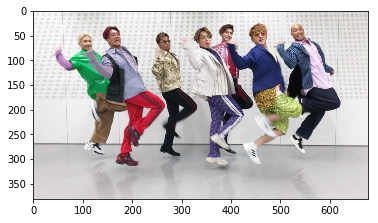

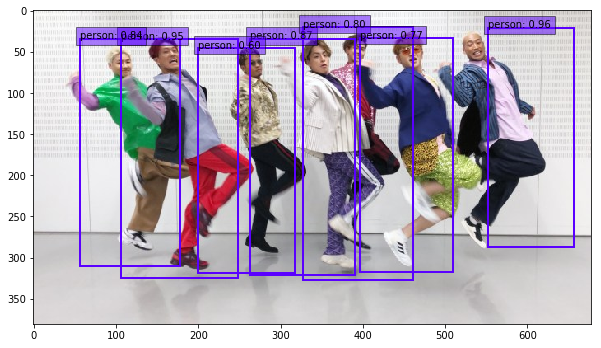

./imgs/sample2.JPG


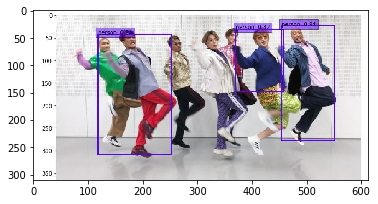

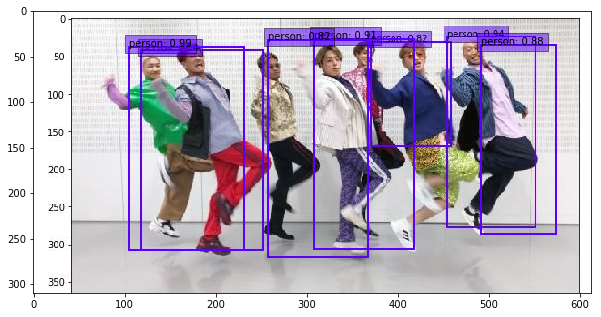

./imgs/a.jpg


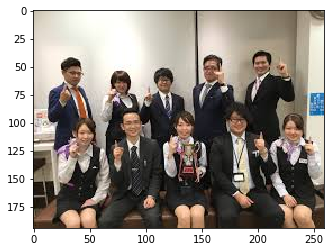

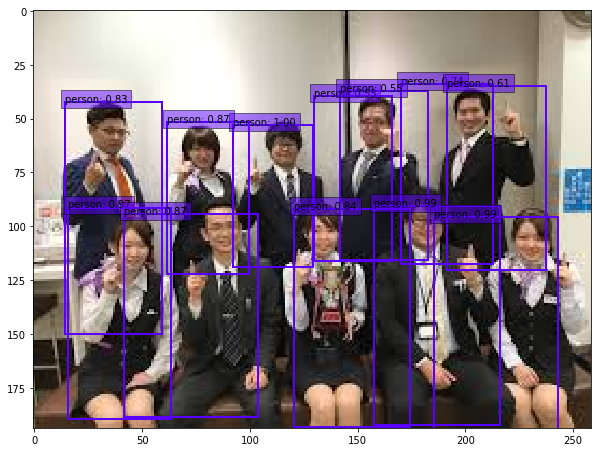

./imgs/syuugou01.jpg


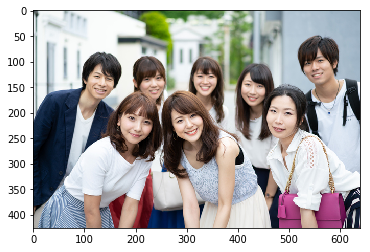

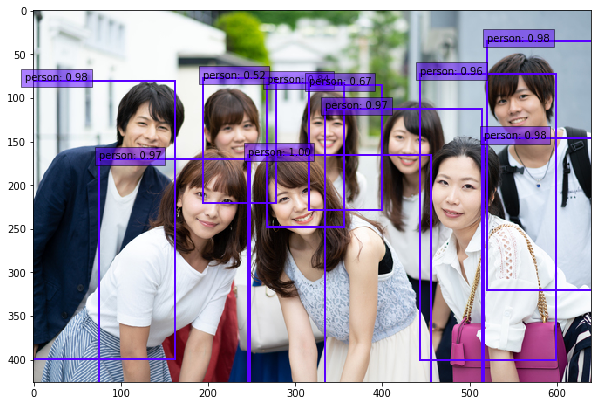

./imgs/EZ6I1552_-720x480.jpg


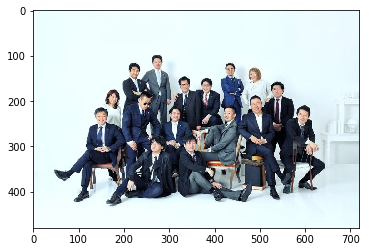

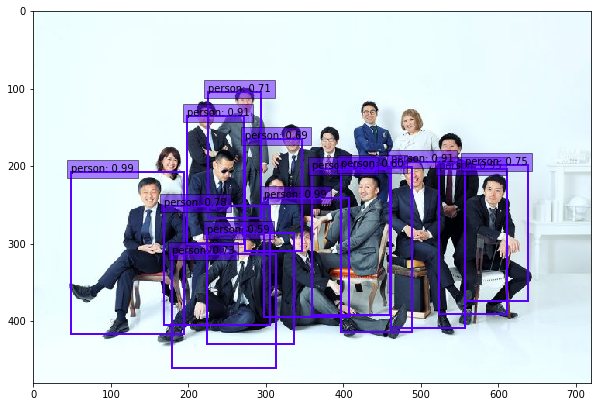

./imgs/main.jpg


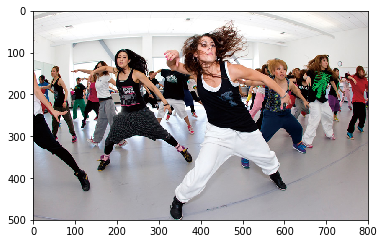

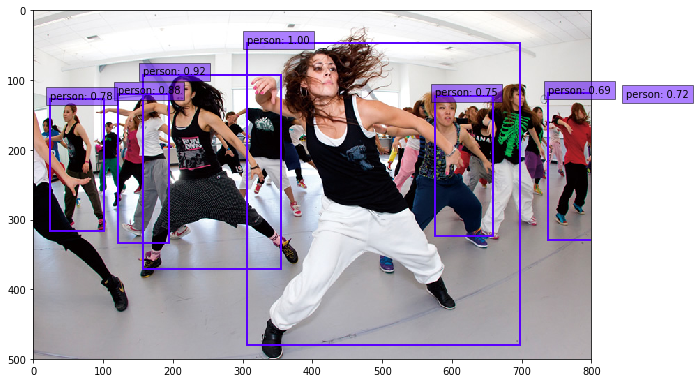

./imgs/b.jpg


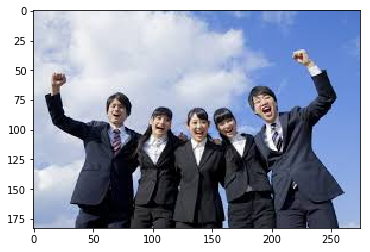

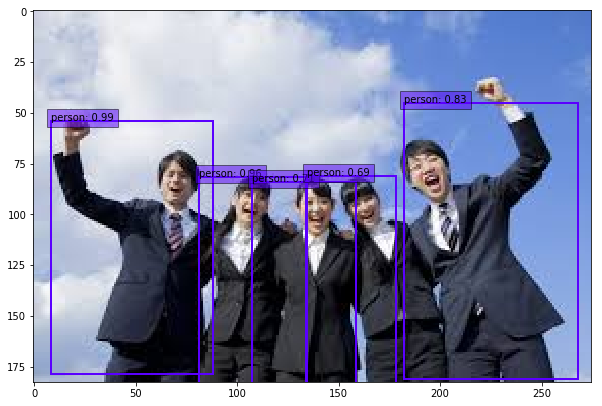

./imgs/img_2cff4a19be74dcd1bc1d54855bd3ec4d207066.jpg


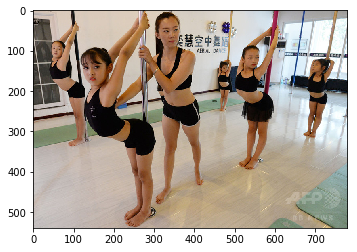

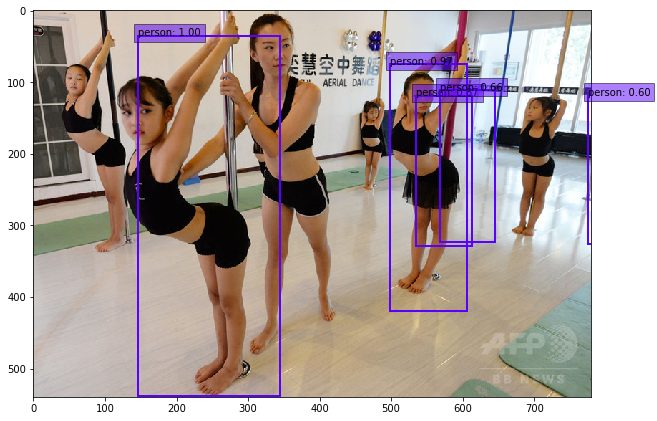

./imgs/TWICE35.jpg


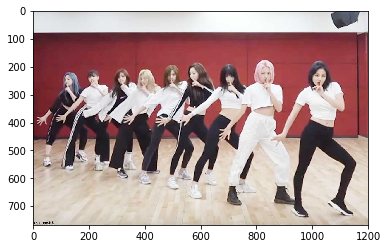

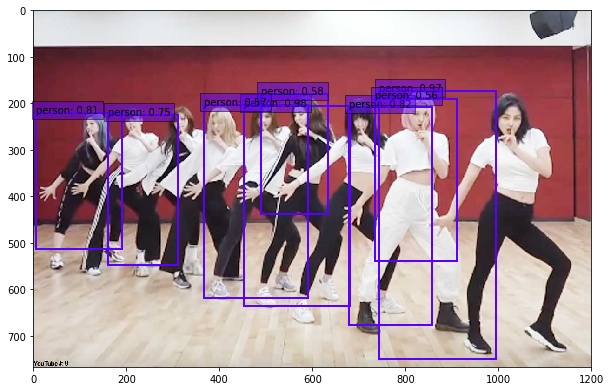

./imgs/AS20190821003362_commL.jpg


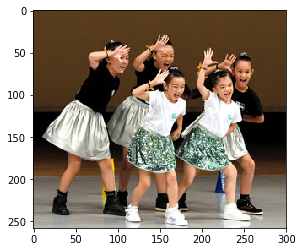

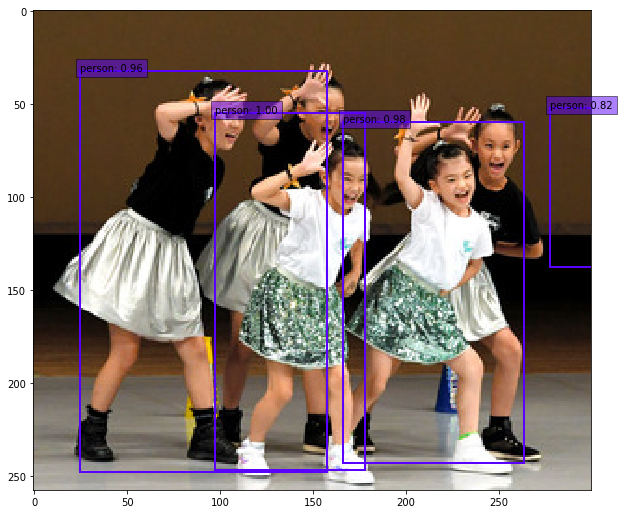

./imgs/1.png


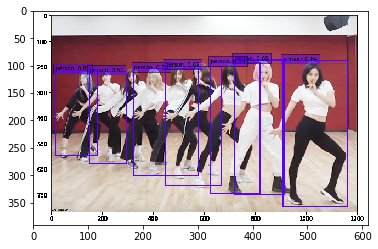

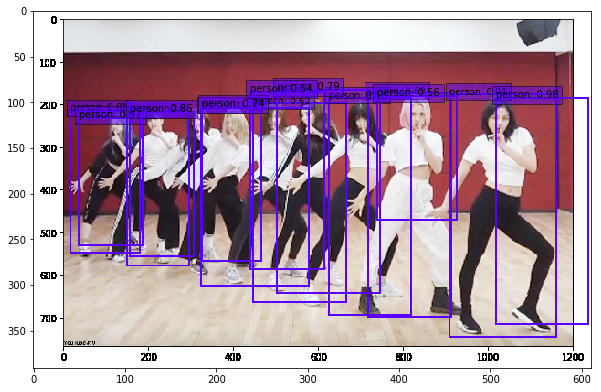

In [12]:
from utils.ssd_model import DataTransform
import glob
# 画像に対する予測
from utils.ssd_predict_show import SSDPredictShow
# 1. 画像読み込み
#image_file_path = "../../VOCdevkit/VOC2007/JPEGImages/009961.jpg"
image_file_path = "./imgs/*"

ssd = SSDPredictShow(eval_categories=voc_classes, net=net, device=device)

for imp in glob.glob(image_file_path):
    print(imp)
    img = cv2.imread(imp)  # [高さ][幅][色BGR]
    height, width, channels = img.shape  # 画像のサイズを取得

    # 2. 元画像の表示
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    
    ssd.show(imp, data_confidence_level=0.5)
    plt.show()


以上